<span style="font-size:2em;">**International football results from 1872 to 2021**</span>

This dataset has more than 42000 results of men's international football matches from 1972 to 2021. 
It includes different competitions like FIFA World Cup and friendly matches and is divided into two files: **results** and **shootouts**. 

The **results** file is composed of the following variables:
- **date** - date of the match.
- **home_team** - the name of the home team.
- **away_team** - the name of the away team.
- **home_score** - full-time home team score including extra time, not including penalty-shootouts.
- **away_score** - full-time away team score including extra time, not including penalty-shootouts.
- **tournament** - the name of the tournament.
- **city** - the name of the city/town/administrative unit where the match was played.
- **country** - the name of the country where the match was played.
- **neutral** - TRUE/FALSE column indicating whether the match was played at a neutral venue.

The **shootouts** csv has 4 columns:
- **date** - date of the match.
- **home_team** - the name of the home team.
- **away_team** - the name of the away team.
- **winner** - winner of the penalty-shootout.

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

# Descriptive Statistics

Let's load the dataset and look at the descriptive statistics.

In [2]:
football_df = pd.read_csv('../data/raw/results.csv')

In [3]:
football_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


The first 5 international football matches were between Scotland and England.

In [4]:
football_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43086 entries, 0 to 43085
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        43086 non-null  object 
 1   home_team   43084 non-null  object 
 2   away_team   43084 non-null  object 
 3   home_score  43081 non-null  float64
 4   away_score  43081 non-null  float64
 5   tournament  43086 non-null  object 
 6   city        43086 non-null  object 
 7   country     43086 non-null  object 
 8   neutral     43084 non-null  object 
dtypes: float64(2), object(7)
memory usage: 3.0+ MB


In [5]:
football_df.describe().T

,count,mean,std,min,25%,50%,75%,max
home_score,43081.0,1.743228,1.753982,0.0,1.0,1.0,2.0,31.0
away_score,43081.0,1.183608,1.400620,0.0,0.0,1.0,2.0,21.0


The team that plays at home scores more goals on average. 

There was one game where the home team scored 31 goals and one where the away team scored 21. Before proceeding, let's check which games are we talking about.

In [6]:
football_df[(football_df["home_score"] == 31) | (football_df["away_score"] == 21)]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
23917,2001-04-11,Australia,American Samoa,31.0,0.0,FIFA World Cup qualification,Coffs Harbour,Australia,False
27494,2005-03-11,Guam,North Korea,0.0,21.0,EAFF Championship,Taipei,Taiwan,True


I thought these games would be way more in the past!

**Australia vs American Samoa** can be considered a David vs Golias fight. Australia have won 4 OFC Nations cups and 1 AFC Asian cup while American Samoa lost 45 of a total of 51 matches in his entire history.

I haven't heard of the **EAFF Championship** until now, it is a competition in East Asia for nations like China, South Korea and Japan. The current champion is South Korea, coached by Portuguese Paulo Bento :)

Missing values might affect the analysis, so we are going to see if there are any.

In [7]:
football_df.isnull().sum()

date          0
home_team     2
away_team     2
home_score    5
away_score    5
tournament    0
city          0
country       0
neutral       2
dtype: int64

There are missing values. Since they are few, let's just ignore them by deleting these rows.

In [8]:
football_df.drop(football_df[football_df.isna().any(axis=1)].index, inplace=True)

# Data Processing

First, we are renaming the columns and their values for plotting purposes.

In [9]:
football_df.rename(columns={'date': 'Date', 
                   'home_team': 'Home Team', 
                   'away_team': 'Away Team',
                   'home_score': 'Home Score',
                   'away_score': 'Away Score',
                   'tournament': 'Tournament',
                   'city': 'City',
                   'country': 'Country',
                   'neutral': 'Neutral'}, inplace=True)

By creating columns with the outcome of the match along with the winning and losing teams we are having quicker access to the result of the match. 

Plus, we are adding some date-related features like year, month and day of week.

In [10]:
football_df['Outcome'] = football_df.apply(lambda x : 'H' if x['Home Score'] > x['Away Score'] 
                                           else ('A' if x['Home Score'] < x['Away Score'] else 'D'),
                                           axis=1)
football_df['Winning Team'] = football_df.apply(lambda x : x['Home Team'] if x['Home Score'] > x['Away Score'] 
                                           else (x['Away Team'] if x['Home Score'] < x['Away Score'] else np.nan),
                                           axis=1)
football_df['Losing Team'] = football_df.apply(lambda x : x['Away Team'] if x['Home Score'] > x['Away Score'] 
                                           else (x['Home Team'] if x['Home Score'] < x['Away Score'] else np.nan),
                                           axis=1)
football_df['Year'] = pd.DatetimeIndex(football_df['Date']).year
football_df['Month'] = pd.DatetimeIndex(football_df['Date']).month
football_df['Day of Week'] = pd.DatetimeIndex(football_df['Date']).day_name()

Before plotting some charts, we should check if the above features were created correctly.

In [11]:
football_df.head(10)

,Date,Home Team,Away Team,Home Score,Away Score,Tournament,City,Country,Neutral,Outcome,Winning Team,Losing Team,Year,Month,Day of Week
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,D,NaN,NaN,1872,11,Saturday
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,H,England,Scotland,1873,3,Saturday
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,H,Scotland,England,1874,3,Saturday
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,D,NaN,NaN,1875,3,Saturday
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,H,Scotland,England,1876,3,Saturday
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Glasgow,Scotland,False,H,Scotland,Wales,1876,3,Saturday
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,London,England,False,A,Scotland,England,1877,3,Saturday
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wrexham,Wales,False,A,Scotland,Wales,1877,3,Monday
8,1878-03-02,Scotland,England,7.0,2.0,Friendly,Glasgow,Scotland,False,H,Scotland,England,1878,3,Saturday
9,1878-03-23,Scotland,Wales,9.0,0.0,Friendly,Glasgow,Scotland,False,H,Scotland,Wales,1878,3,Saturday


We are ready to plot!

# Data Visualization

Let's go through the rest of this notebook creating different charts to answer a few questions.

**Which tournaments had the most games?**

To answer this, we are excluding friendly matches, qualifiers and tournaments with less than 100 matches.

In [12]:
tournament_counts = pd.DataFrame(football_df["Tournament"].value_counts().reset_index()) \
    .rename(columns={'index': 'Tournament', 'Tournament': 'Count'})

tournament_counts = tournament_counts[(tournament_counts["Tournament"] != "Friendly") & 
                                      (~ tournament_counts["Tournament"].str.endswith('qualification')) & 
                                      (tournament_counts["Count"] >= 100)]
tournament_counts.reset_index(inplace=True)

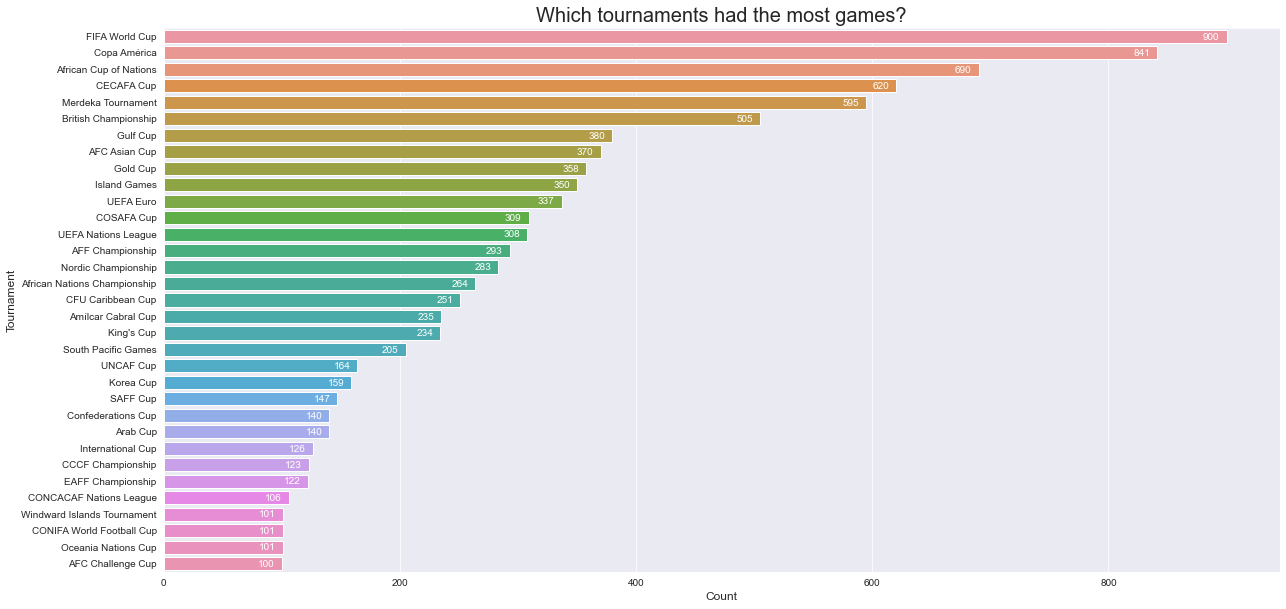

In [64]:
plt.figure(figsize=(20,10))
ax = sns.barplot(y=tournament_counts["Tournament"], x=tournament_counts["Count"], orient='h')
ax.set_title("Which tournaments had the most games?", size=20)
ax.set_xlabel(xlabel="Count", size=12)
ax.set_ylabel(ylabel="Tournament", size=12)

# Annotate value labels to each type
for index, value in tournament_counts.iterrows(): 
    plt.annotate(value['Count'], xy=(value['Count'] - 20, index + 0.2), color='white')

We will consider two competitions played between teams from all continents (World Cup and Confederations Cup) and the main competitions of each continent. So, these are the tournaments in the dataset that we will take as the main ones:
- FIFA World Cup
- Confederations Cup
- Copa América
- African Cup of Nations
- African Nations Championship	
- AFC Asian Cup
- Gold Cup
- CONCACAF Nations League
- UEFA Euro
- UEFA Nations League
- Oceania Nations Cup

Now we are ready to look at the top 10 of the teams that have played the most games in major tournaments.

**Which national teams have played the most games in major tournaments?**

In [14]:
major_tournaments = ['FIFA World Cup', 'Confederations Cup', 'Copa América', 'African Cup of Nations', 
                     'African Nations Championship', 'AFC Asian Cup', 'Gold Cup', 'CONCACAF Nations League', 
                     'UEFA Euro', 'UEFA Nations League', 'Oceania Nations Cup']

major_tournaments_df = football_df[football_df["Tournament"].isin(major_tournaments)]

In [50]:
home_team_game_counts = major_tournaments_df[major_tournaments_df["Neutral"] == False]["Home Team"].value_counts()

neutral_team_game_counts = pd.concat([major_tournaments_df[major_tournaments_df["Neutral"] == True]["Home Team"].value_counts(),
           major_tournaments_df[major_tournaments_df["Neutral"] == True]["Away Team"].value_counts()], axis=1)
neutral_team_game_counts["Neutral"] = neutral_team_game_counts["Home Team"] + neutral_team_game_counts["Away Team"]

away_team_game_counts = major_tournaments_df[major_tournaments_df["Neutral"] == False]["Away Team"].value_counts()

game_counts = pd.concat([home_team_game_counts, neutral_team_game_counts["Neutral"], away_team_game_counts], axis=1)
game_counts["Total"] = game_counts["Home Team"] + game_counts["Neutral"] + game_counts["Away Team"]
game_counts_top10 = game_counts.sort_values(by="Total", ascending=False).head(10)

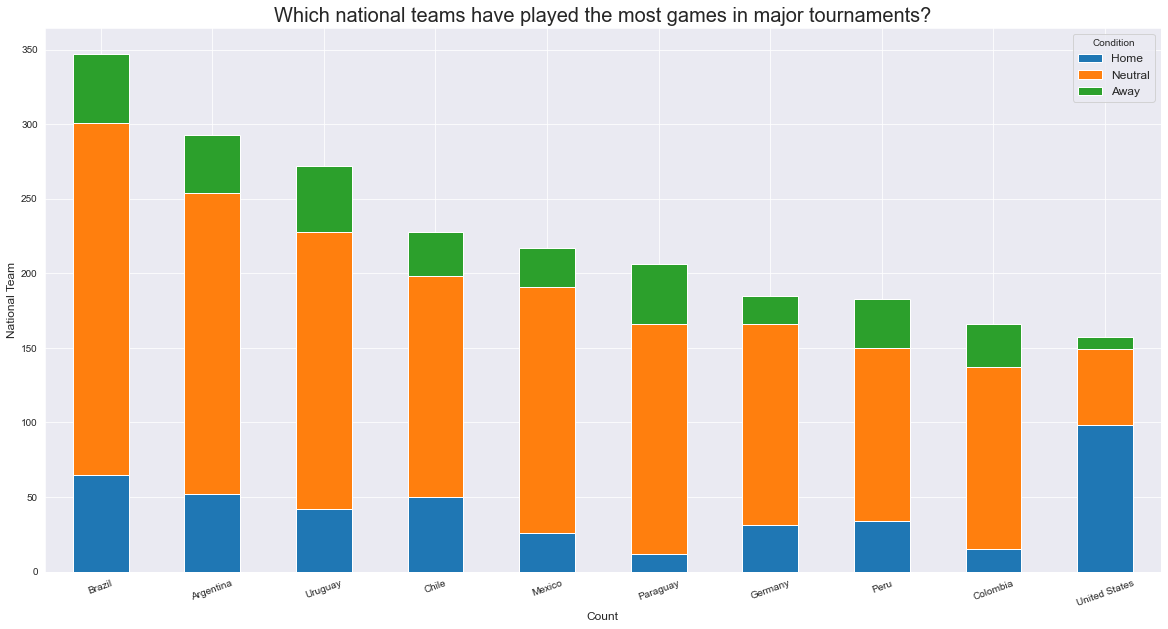

In [63]:
ax = game_counts_top10[["Home Team", "Neutral", "Away Team"]].plot(kind="bar", stacked=True, figsize=(20,10))
ax.set_title("Which national teams have played the most games in major tournaments?", size=20)
ax.set_xlabel(xlabel="Count", size=12)
ax.set_ylabel(ylabel="National Team", size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20);
ax.legend(["Home", "Neutral", "Away"], loc="upper right", title="Condition", fontsize=12);

It makes sense that teams from **South America (Brazil, Argentina, Uruguay, Chile, Paraguay, Peru and Colombia)** dominate this top 10. Copa América is the second most played tournament among the considered as major. Plus, the top 3 (Brazil, Argentina and Uruguay) add up to nine World Cups,  thirty nine Copa Américas, and five Confederations Cups!

Brazil, Colombia and Peru were invited to the Gold Cup. In three editions, Brazil was runner-up twice and third once. Colombia also played three times, reaching the final once and Peru reached the semifinals the only time they played in this competition.

**Mexico** is the most powerful team in the CONCACAF region. Mexico has won eleven Gold Cups and one Confederations Cup.

**Germany** is the only European team that appears, which is explained by the fact that it is the most successful European team. It has won four World Cups, three Euros and one Confederations Cup. 

**United States** has won seven Gold Cups and one CONCACAF Nations League (there has been only one edition). The high number of home games for the United States is due to having been the hosts or co-hosts of all editions of the Gold Cup. 

Mexico and the United States have participated in 10 and 4 editions of the Copa América. Mexico achieved two second places and three third places, while the United States finished fourth twice. This also contributed to the high number of games played by these two nations.